In [1]:
run_name = "example"
model_name = "AA_to_PAM_linear" # Don't change

# Optimization parameters:
ALPHA = 10 # alpha parameter for Ridge regularization

# !!!!!!
random_seed = 0
test_fraction = 0.2


# data parameters
three_nt_PAM = True # Unless this is true will assume you are using 4nt PAM
LOW_RATE_CONSTANT_CUTOFF = -5
LOW_RATE_REPLACE = -5
HEATMAP_MAX = -1.5
HEATMAP_MIN = -5
plt_test_data = False
randomly_over_sample_by_most_active_PAM = True
encoding = 'onehot_plus_pairs' # either 'georgiev' or 'onehot' or 'onehot_plus_pairs'



train_and_test_samples_csv = "./training_data/220924_6pos_selected_random_only.csv"



nts = ["A", "C", "G", "T"]
muts = ['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337']
pams_2_3_4 = ['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG',
       'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA',
       'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG',
       'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA',
       'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG',
       'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA',
       'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']
pams = ["N" + x for x in pams_2_3_4]

In [2]:
from functions import *
import numpy as np
from scipy import stats
import pandas as pd
import random as rand
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

rand.seed(random_seed)



# Write the parameters to log
if not os.path.isdir("./PAMmla outputs"):
    os.mkdir("./PAMmla outputs")
if not os.path.isdir("./PAMmla outputs/" + model_name):
    os.mkdir("./PAMmla outputs/" + model_name)
run_directory_path = "./PAMmla outputs/" + model_name + "/" + run_name
if not os.path.isdir(run_directory_path):
    os.mkdir(run_directory_path)
all_vars = dir()
with open("".join([run_directory_path,'/variables_log.txt']), 'w') as f:
    for name in all_vars:
        if not name.startswith('_') and "<" not in str(eval(name)):
            line = "".join([name, " = ", str(eval(name)), " \n"])
            f.write(line)

# pickle the parameters
filename = "".join([run_directory_path, "/data_parameters.pkl"])
with open(filename, 'wb') as f:
    pickle.dump([run_name, model_name, three_nt_PAM, test_fraction, LOW_RATE_CONSTANT_CUTOFF, LOW_RATE_REPLACE, HEATMAP_MAX, HEATMAP_MIN, nts, muts, pams], f)


In [3]:
train_test_PAMDA_df = pd.read_csv(train_and_test_samples_csv)
# make very low rate constants a very small number to get rid of noise (the very low ones are not meaningful)
train_test_PAMDA_df[pams] = np.where(train_test_PAMDA_df[pams] <= LOW_RATE_CONSTANT_CUTOFF, LOW_RATE_REPLACE, train_test_PAMDA_df[pams])
# normalize the data
DATA_MEAN = np.mean(np.array(train_test_PAMDA_df[pams]).flatten())
DATA_STD = np.std(np.array(train_test_PAMDA_df[pams]).flatten())
print("MEAN: ", DATA_MEAN)
print("STD: ", DATA_STD)

filename = "".join([run_directory_path, "/mean_std.pkl"])
with open(filename, 'wb') as f:
    pickle.dump([DATA_MEAN, DATA_STD], f)

for col in pams:
    train_test_PAMDA_df[col] = normalize(train_test_PAMDA_df[col], DATA_MEAN, DATA_STD)

# add the amino acid encodings
if encoding == "onehot":
    train_test_enc = add_onehot(train_test_PAMDA_df, muts) # returns the encoder, dataframe is mutated in place
elif encoding == "georgiev":
    train_test_enc = add_georgiev(train_test_PAMDA_df, muts) # returns the encoder, dataframe is mutated in place
elif encoding == "onehot_plus_pairs":
    train_test_enc = add_onehot_plus_pairs(train_test_PAMDA_df, muts) # returns the encoder, dataframe is mutated in place
else:
    raise Exception("No valid amino acid encoding chosen")
    
    
filename = "".join([run_directory_path, "/encoder.pkl"])
with open(filename, 'wb') as f:
    pickle.dump(train_test_enc, f)

print("Feature encoding shape:")
print(train_test_PAMDA_df["muts_encoded"][0].shape)


MEAN:  -4.787378101407691
STD:  0.536670902831007
Feature encoding shape:
(6120,)


In [4]:
data = train_test_PAMDA_df

# randomly choose samples for test data set and train data set
test_size = int(test_fraction * len(data))
indexes = np.array(range(len(data)))
test_indexes = rand.sample(set(indexes), test_size)
train_indexes = np.delete(indexes, test_indexes)

train_PAMDA_df = data.iloc[train_indexes, :]
test_PAMDA_df = data.iloc[test_indexes, :]
train_PAMDA_df = train_PAMDA_df.reset_index(drop=True)
test_PAMDA_df = test_PAMDA_df.reset_index(drop=True)

print("TRAIN STD", np.std(np.array(train_PAMDA_df[pams]).flatten()))
print("TEST MEAN", np.mean(np.array(test_PAMDA_df[pams]).flatten()))
print("TEST STD", np.std(np.array(test_PAMDA_df[pams]).flatten()))


# add max PAM column if we are over-sampling by most active PAM
if randomly_over_sample_by_most_active_PAM:
    add_max_PAM_col(train_PAMDA_df, pams)
    

train_PAMDA_df.to_csv("".join([run_directory_path, "/training_data_norm.csv"]))
test_PAMDA_df.to_csv("".join([run_directory_path, "/test_data_norm.csv"]))

print("train length:", len(train_PAMDA_df))
print("test length:", len(test_PAMDA_df))


# visualize test data
if plt_test_data:
    for i in range(len(test_PAMDA_df)):
        row = test_PAMDA_df.loc[i, :]
        rates = row[pams] 
        name = row['name']
        plt.figure(figsize = (5,1.5))
        figs_dir = run_directory_path + "/figures"
        if not os.path.isdir(figs_dir):
            os.mkdir(figs_dir)
        output_dir = run_directory_path + "/figures/test_set_heatmaps"
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
        stripped_name = name.strip(r'[\\/*?:"<>|]')
        ax = plot_heatmap(unnormalize(rates, DATA_MEAN, DATA_STD), stripped_name, HEATMAP_MAX, HEATMAP_MIN)
        plt.savefig(output_dir + "/" + stripped_name + ".png", bbox_inches='tight')
        plt.show()

TRAIN STD 0.9938601017347133
TEST MEAN 0.01073690007122271
TEST STD 1.024121228878953
train length: 616
test length: 154


In [5]:
def get_x_y(from_df):
    """
    Take in PAMDA data frame and return x and y (inputs and labels respectively)
    - x is list of one hot encoding positions
    - y is list of pam profiles (array length 256 or 64 of log_k values)
    """
    mut_df = from_df["muts_encoded"]
    pam_df = from_df[pams]
    x = []
    y = []
    for i in range(len(mut_df)):
        x_curr = mut_df.iloc[i]
        y_curr = pam_df.iloc[i]
        x.append(x_curr)
        y.append(y_curr)  
    assert(len(x) == len(y) == len(mut_df))
    return (np.array(x), np.array(y))

## 5 fold internal cross val

In [6]:
def cross_val(PAMDA_df, ros):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    splits = kf.split(PAMDA_df)
    scores = []
    scores_by_hd = []
    for (train_ind, val_ind) in splits:
        train_df = PAMDA_df.iloc[train_ind]
        val_df = PAMDA_df.iloc[val_ind]
        # over sample each split separately if ros true
        if ros:
            train_df = ros_by_column(train_df, "max_PAM")
        # get the variant names from training examples
        names = np.array(["".join(PAMDA_df[muts].iloc[i,:]) for i in range(len(PAMDA_df))])
        train_names = names[train_ind]
        val_names = names[val_ind]
        val_hds = hd_to_train_set(val_names, train_names)
        # now that we have over-sampled, get x and y
        x_train, y_train = get_x_y(train_df)
        x_val, y_val = get_x_y(val_df)
        model = Ridge(alpha=ALPHA).fit(x_train, y_train)
        preds = model.predict(x_val)
        scores.append(r2_score(y_val.flatten(), preds.flatten()))
        # also get scored by hamming distance
        scores_by_hd_curr = []
        for i in range(1, max(val_hds)+1):
            ind = [x == i for x in val_hds]
            n = sum(ind)
            score_by_hd = r2_score(y_val[ind].flatten(), preds[ind].flatten())
            scores_by_hd_curr.append((i, n, score_by_hd))
        scores_by_hd.append(scores_by_hd_curr)
    return scores, scores_by_hd

cross_val_scores, cross_val_scores_by_hd = cross_val(train_PAMDA_df, randomly_over_sample_by_most_active_PAM)
print("CROSS VAL R^2", cross_val_scores)
print("MEAN R^2", np.mean(cross_val_scores))
print("STD R^2", np.std(cross_val_scores))
print("CROSS VAL BY HD R^2:")
for x in cross_val_scores_by_hd:
    print(x)


CROSS VAL R^2 [0.78217637515612, 0.8104060320300731, 0.7954292755414465, 0.8082359116110533, 0.8250200919119726]
MEAN R^2 0.804253537250133
STD R^2 0.014492970509316508
CROSS VAL BY HD R^2:
[(1, 13, 0.88145639807968), (2, 59, 0.8221003024115198), (3, 48, 0.6992668990737615), (4, 4, 0.7347441782369294)]
[(1, 14, 0.9049678818018746), (2, 42, 0.8104576823922846), (3, 58, 0.7819998362624192), (4, 9, 0.5047538223780923)]
[(1, 13, 0.8909704839837431), (2, 58, 0.8371972005672628), (3, 39, 0.7023890385190255), (4, 13, 0.13032860712431749)]
[(1, 15, 0.8934210955977279), (2, 45, 0.8435453987573719), (3, 54, 0.7277861019549727), (4, 9, 0.5165500361426495)]
[(1, 13, 0.899919362325707), (2, 51, 0.8603629671076809), (3, 49, 0.7618673327574178), (4, 10, 0.010635288233374673)]


## Fit regressor on whole train set

In [7]:
# over sample before fitting the model
if randomly_over_sample_by_most_active_PAM:
    train_PAMDA_df = ros_by_column(train_PAMDA_df, "max_PAM")
    
# get x and y
x_train, y_train = get_x_y(train_PAMDA_df)
x_test, y_test = get_x_y(test_PAMDA_df)

print("x train:", x_train.shape)
print("x test:", x_test.shape)
print("y train:", y_train.shape)
print("y test:", y_test.shape)


regr = Ridge(alpha=ALPHA).fit(x_train, y_train)



x train: (4972, 6120)
x test: (154, 6120)
y train: (4972, 64)
y test: (154, 64)


## Predict test set

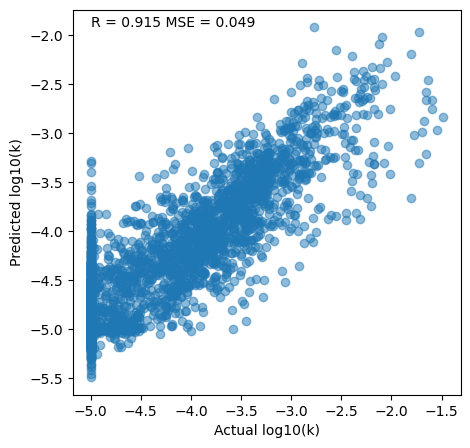

R^2 on test set: 0.8367104567140389


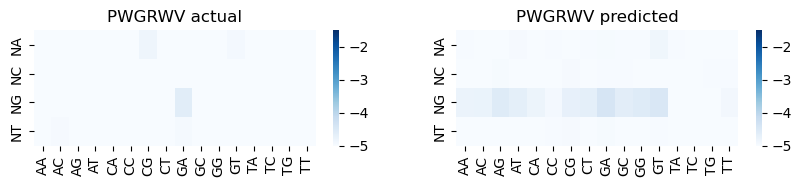

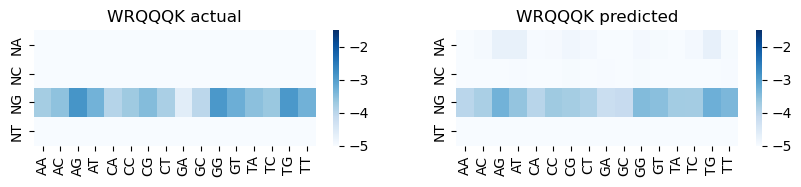

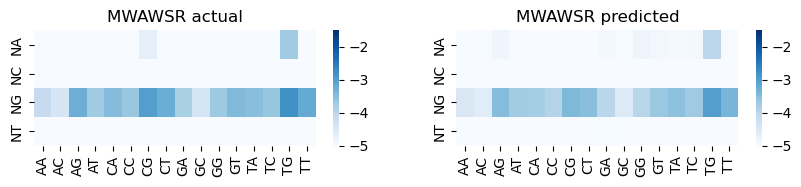

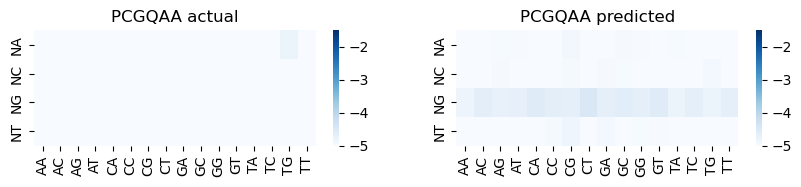

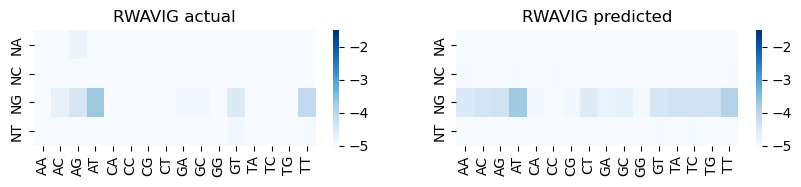

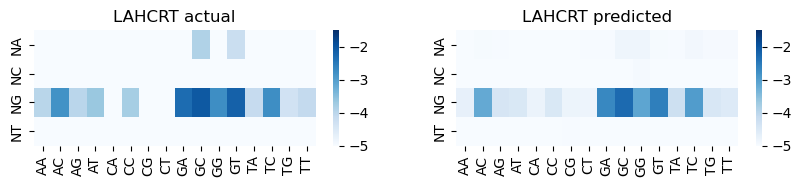

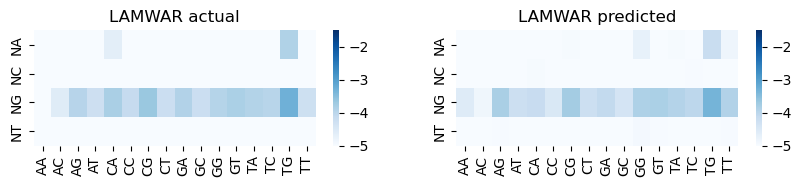

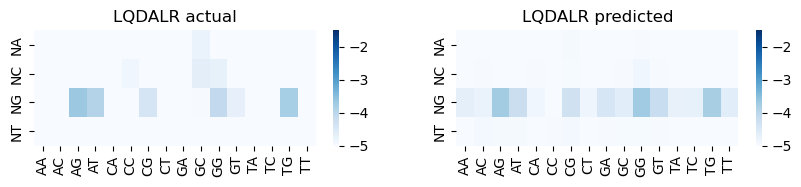

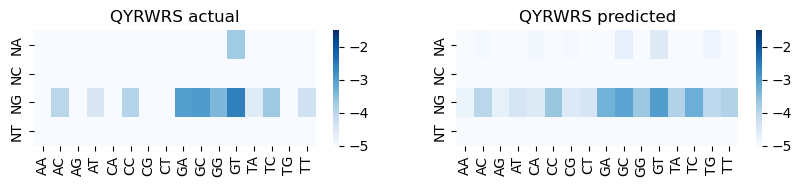

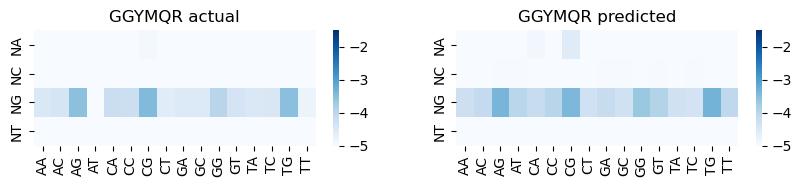

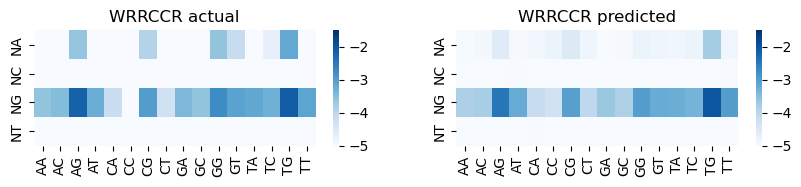

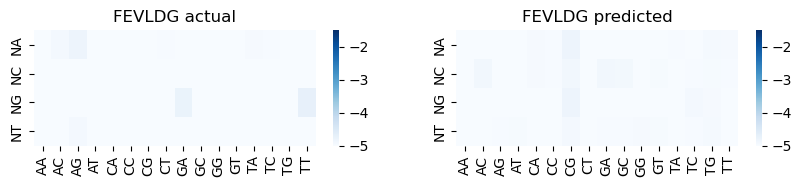

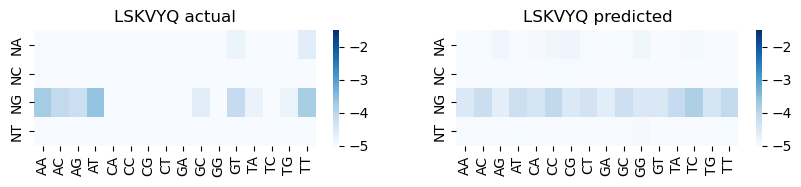

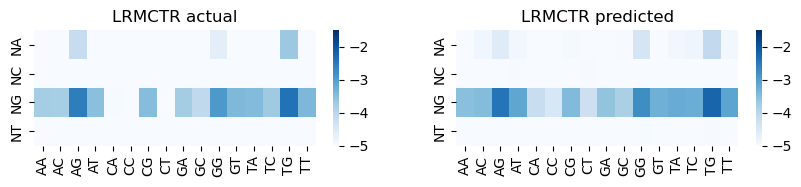

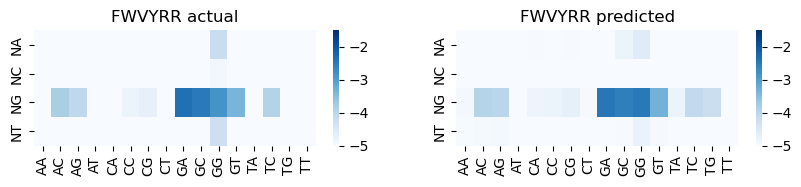

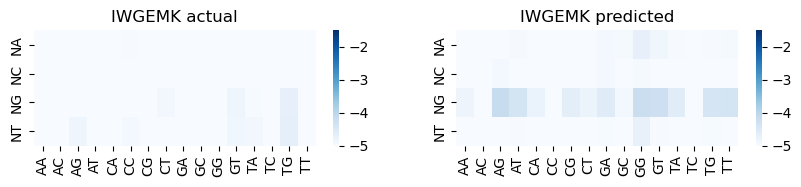

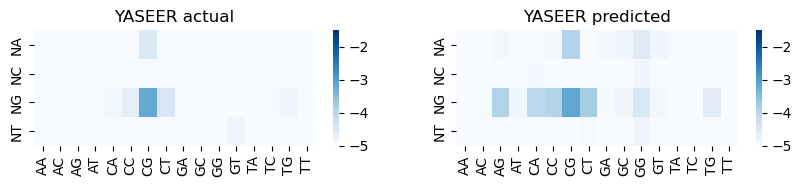

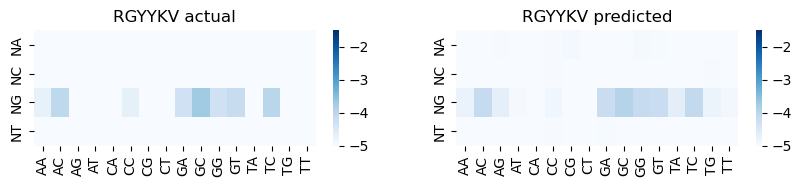

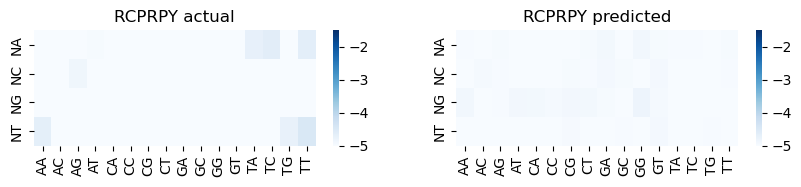

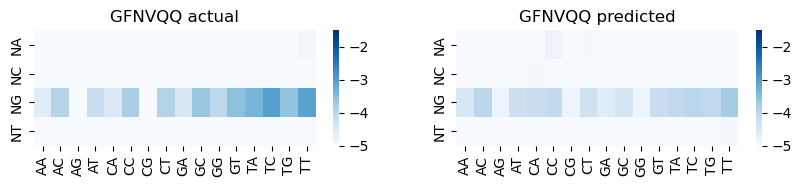

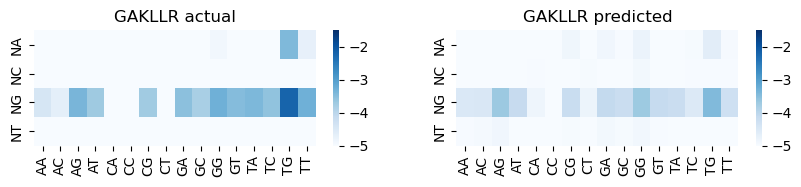

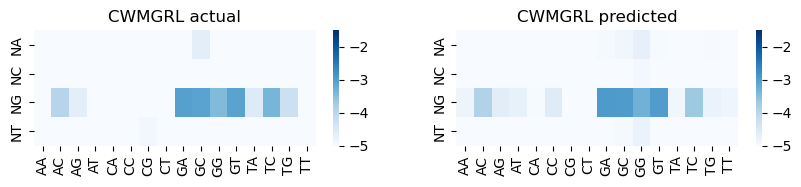

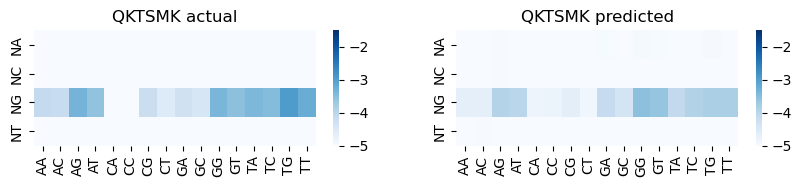

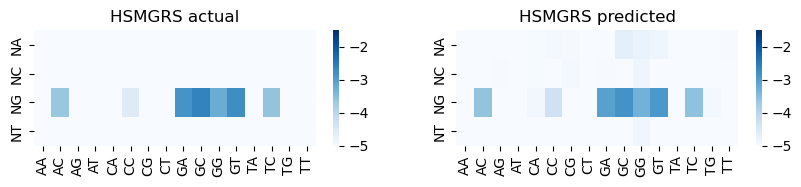

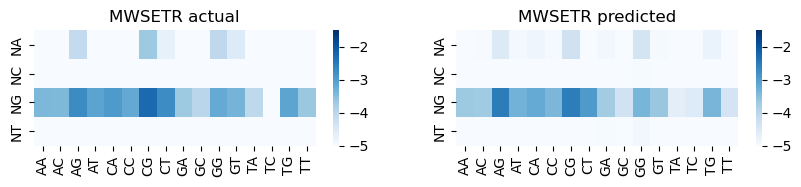

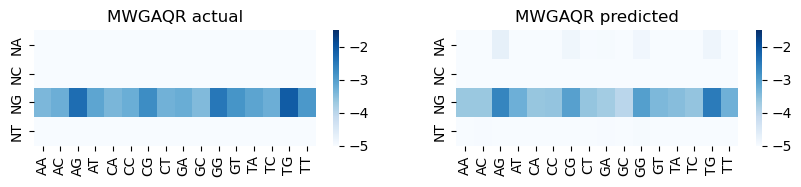

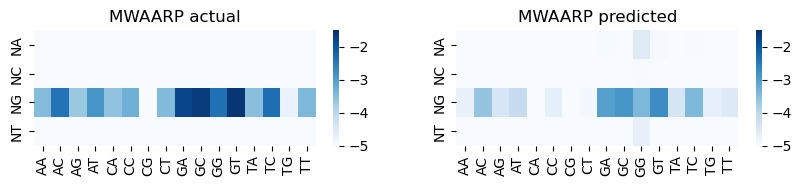

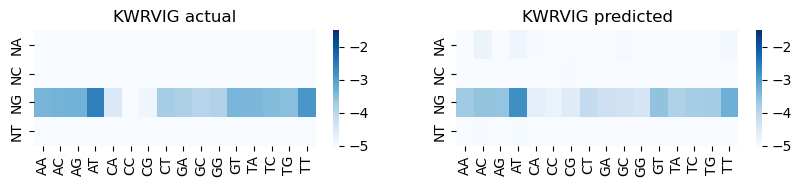

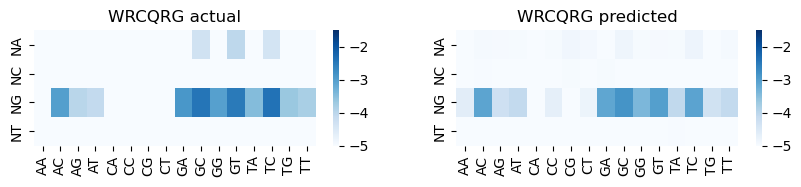

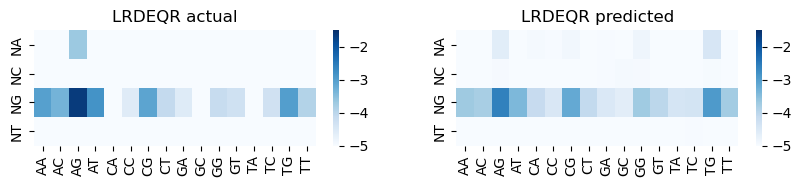

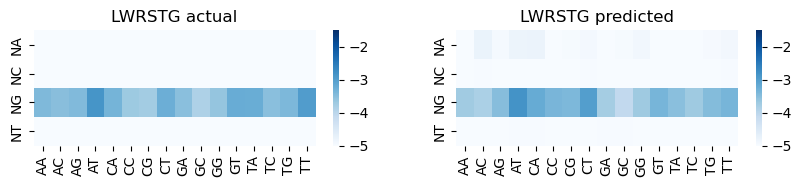

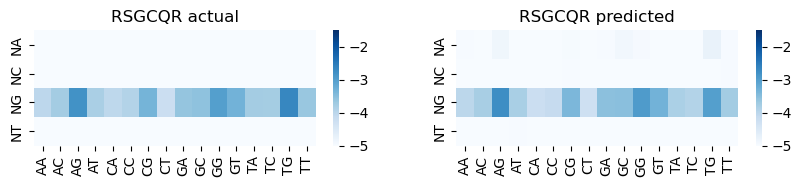

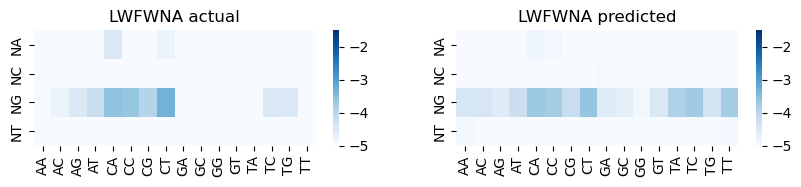

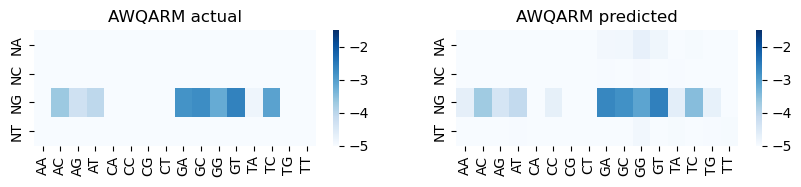

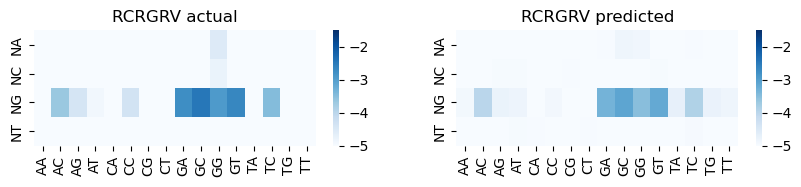

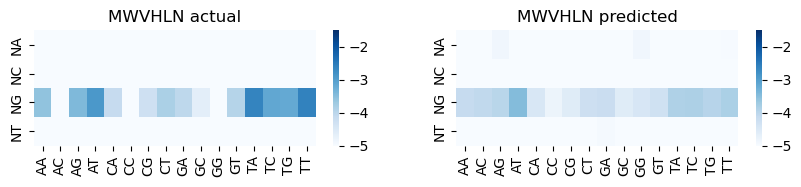

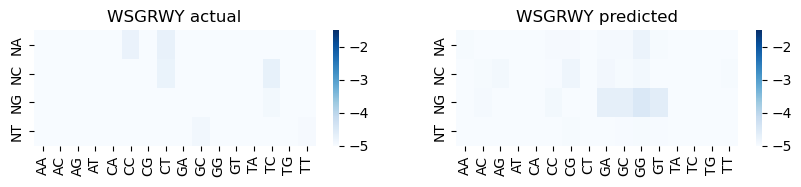

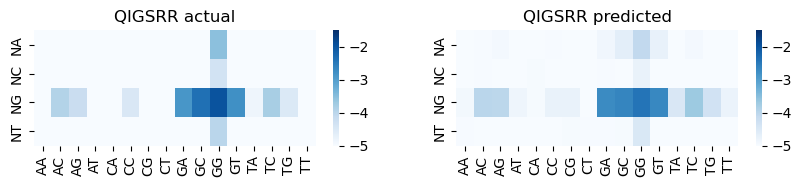

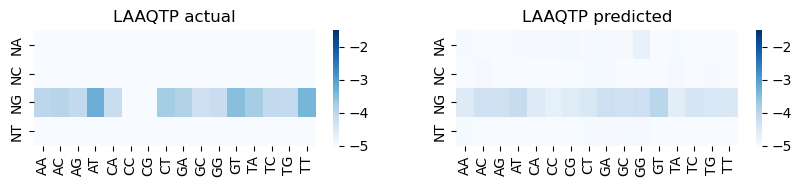

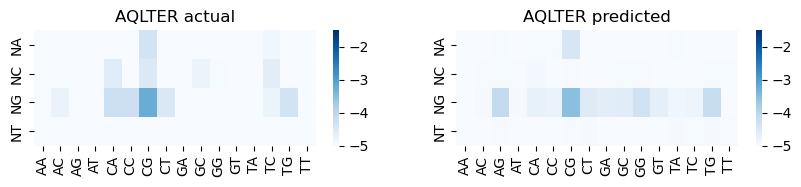

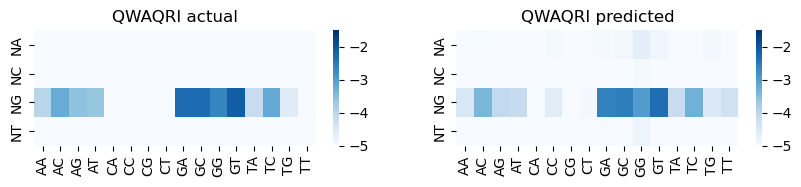

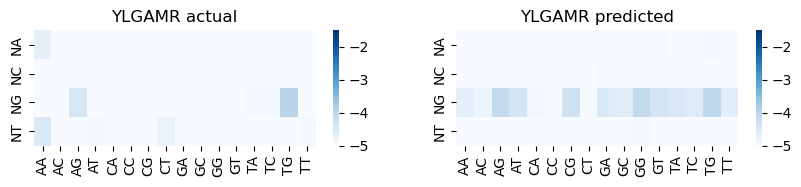

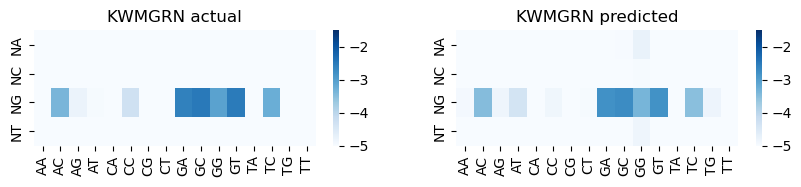

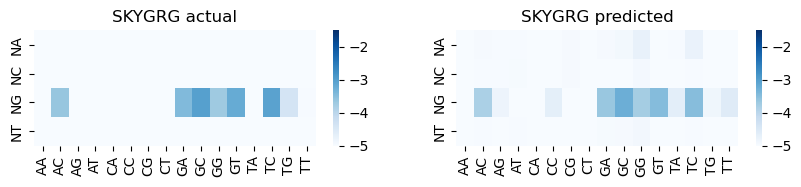

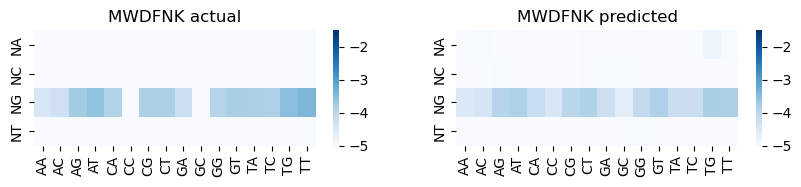

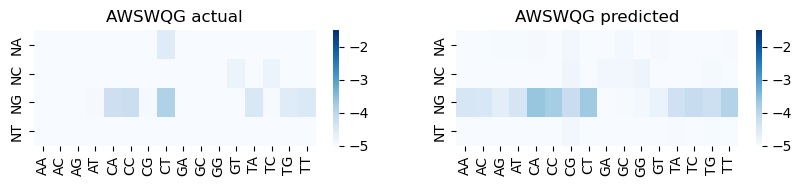

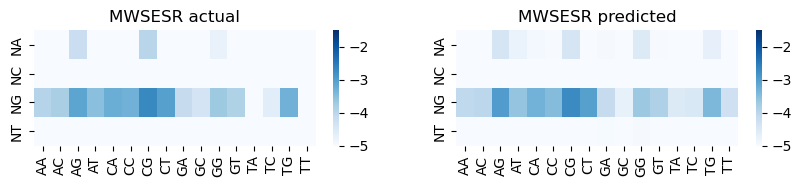

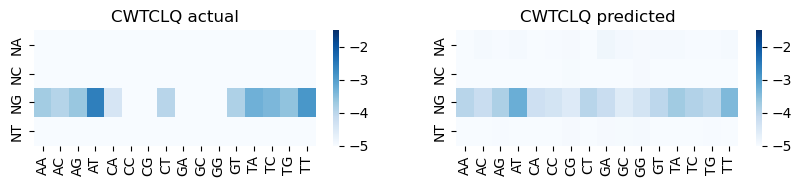

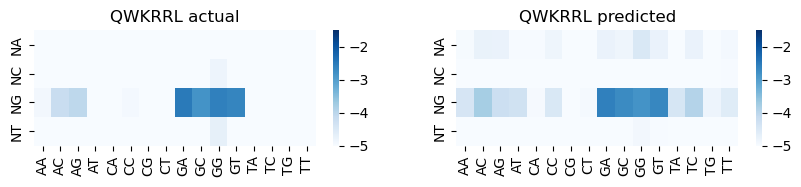

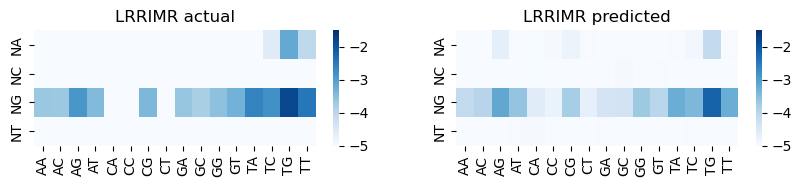

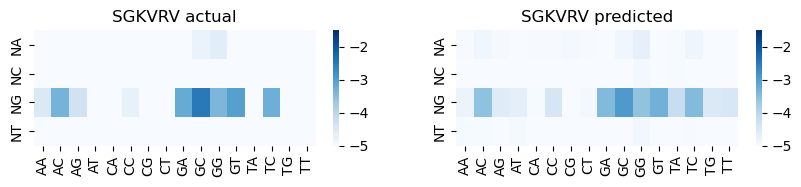

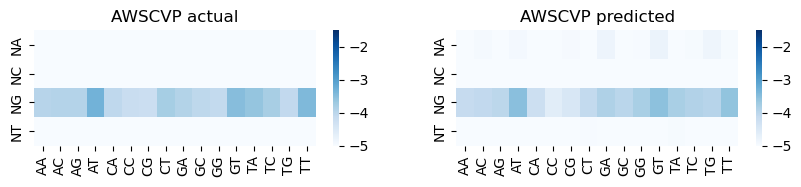

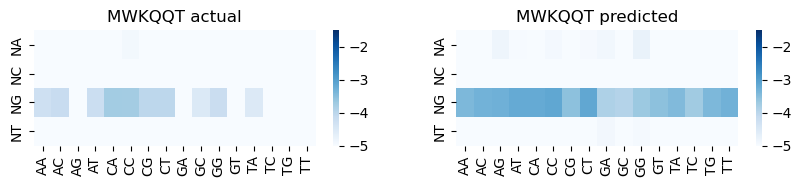

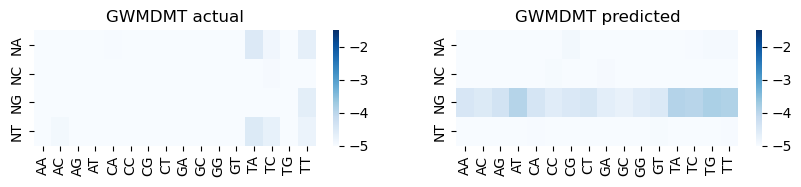

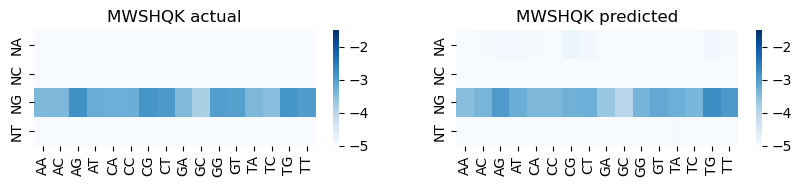

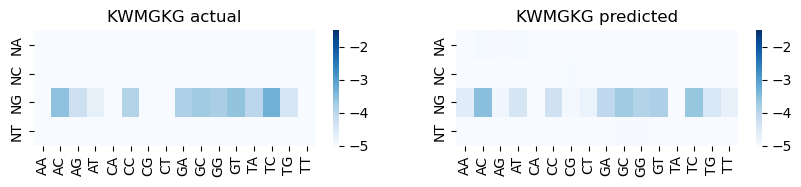

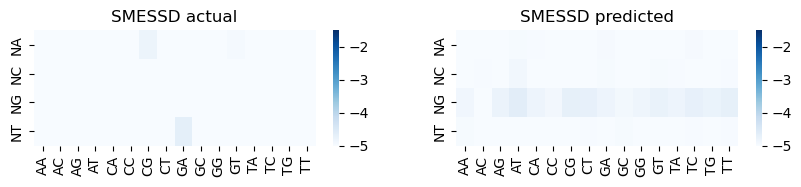

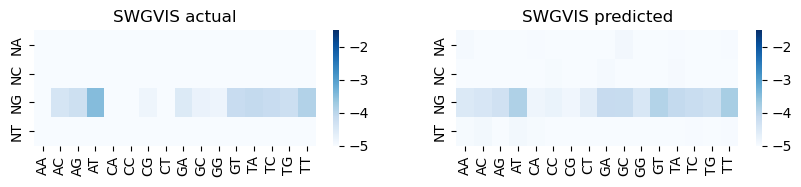

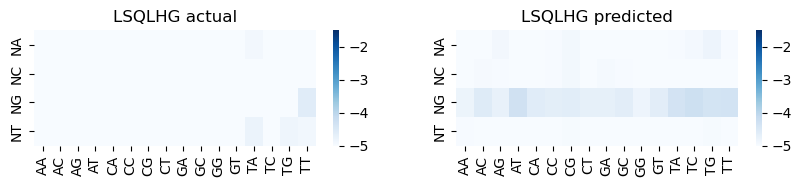

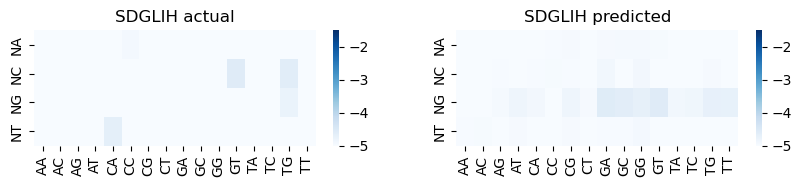

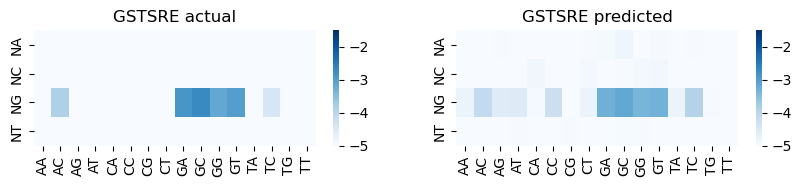

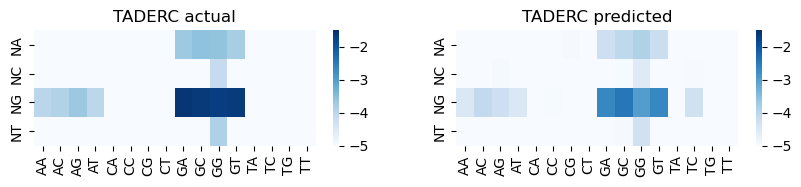

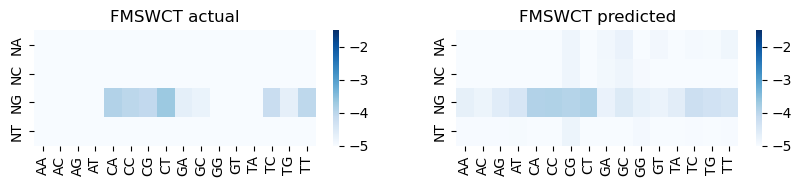

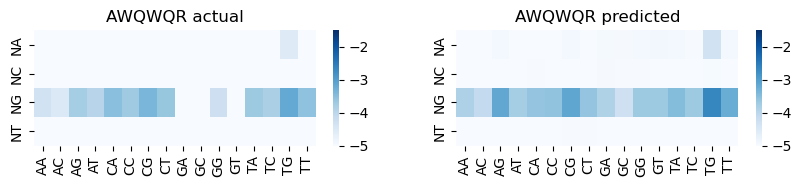

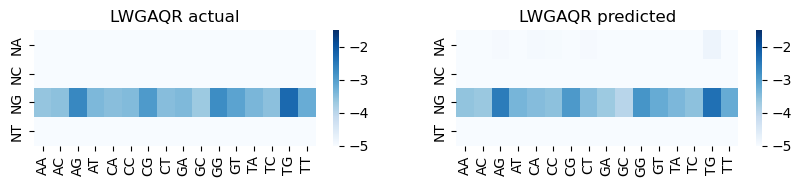

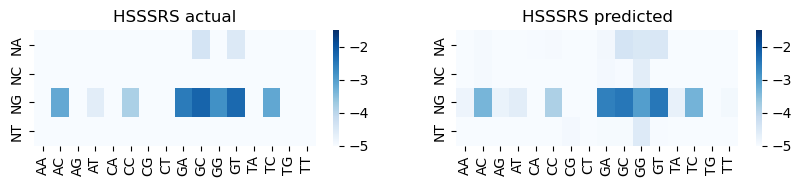

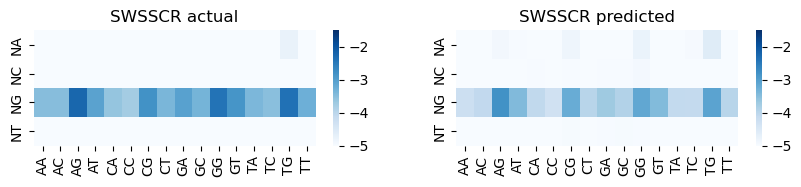

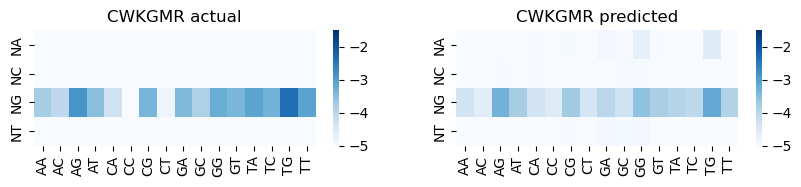

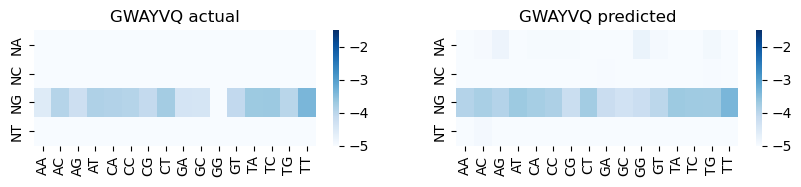

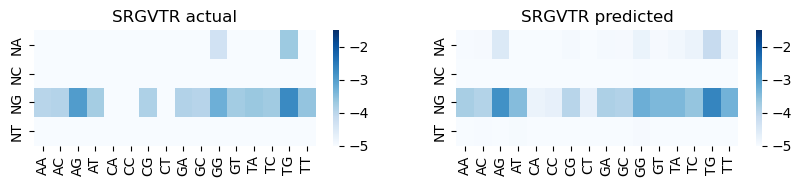

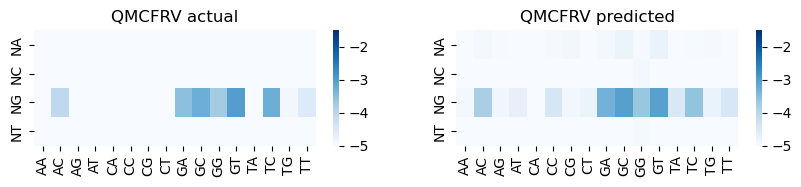

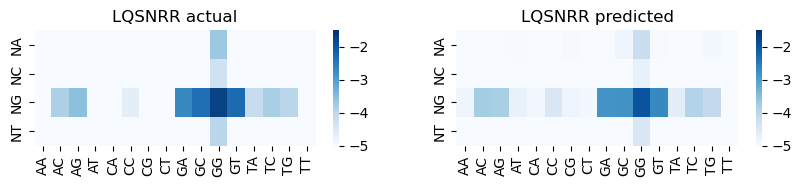

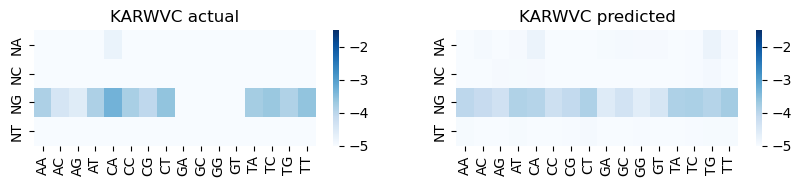

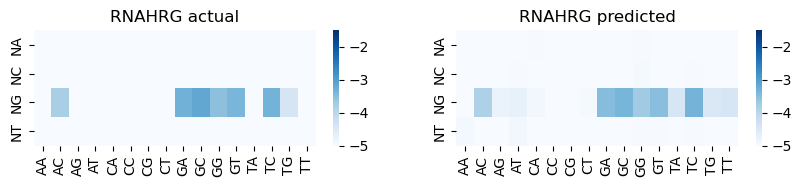

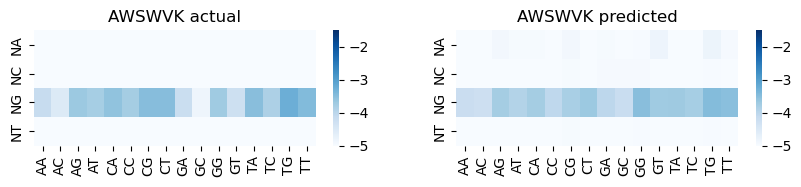

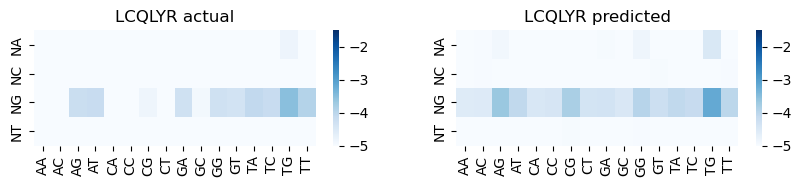

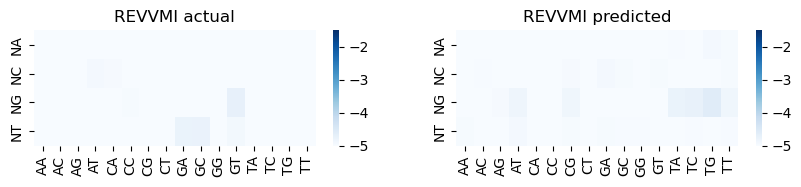

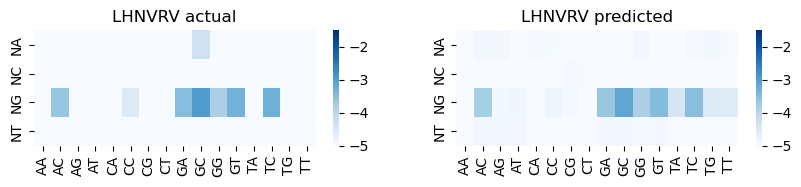

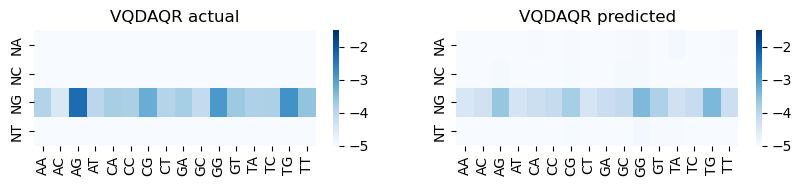

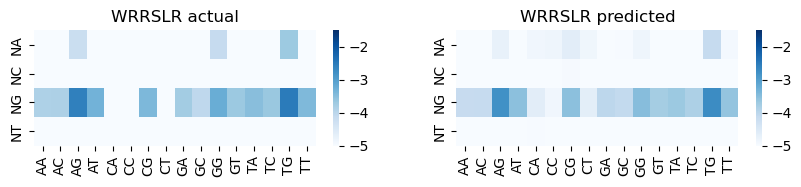

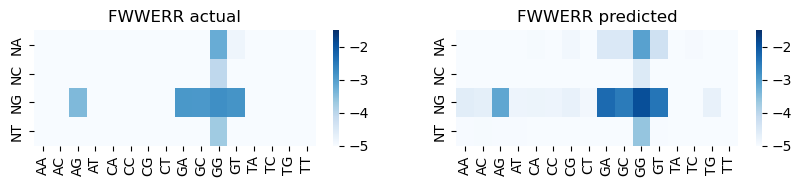

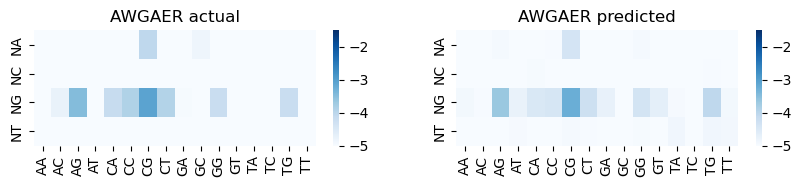

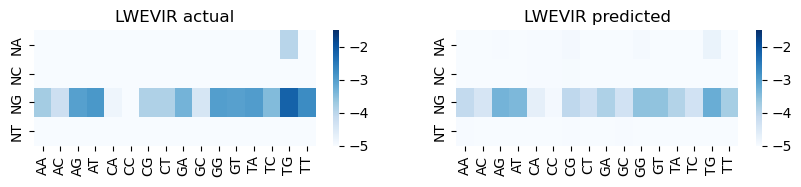

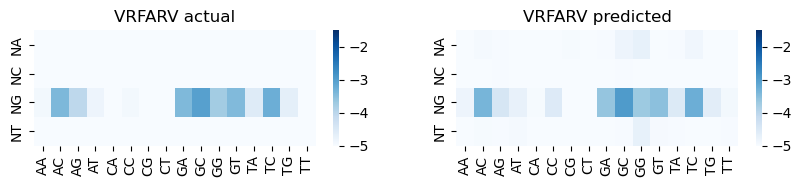

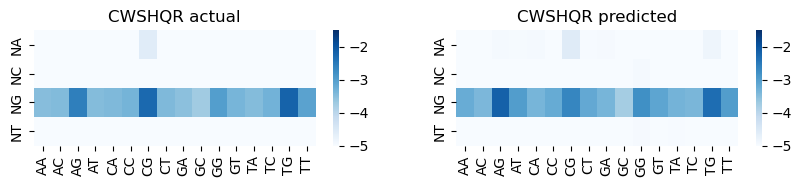

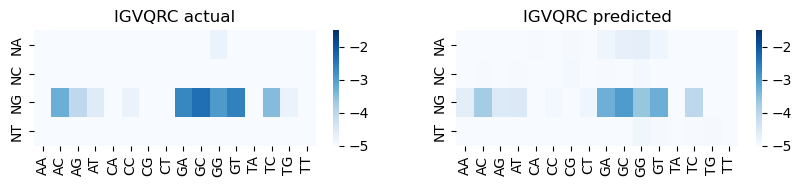

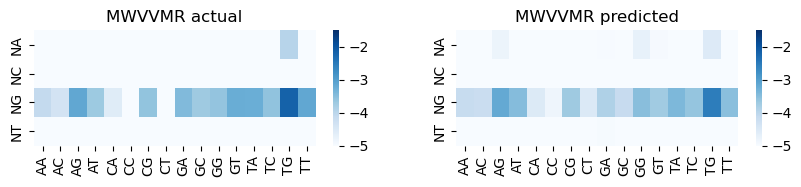

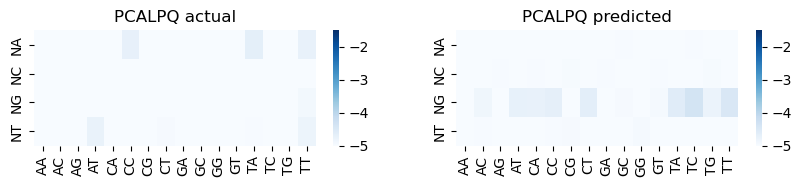

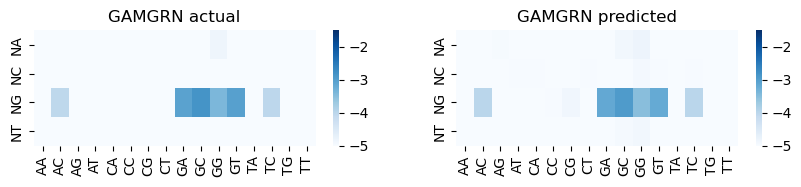

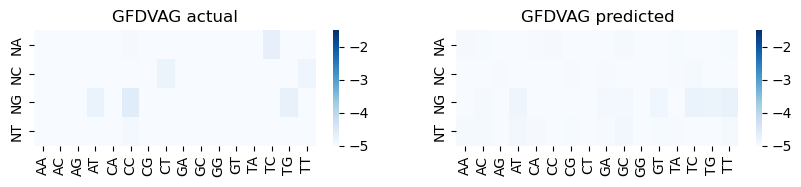

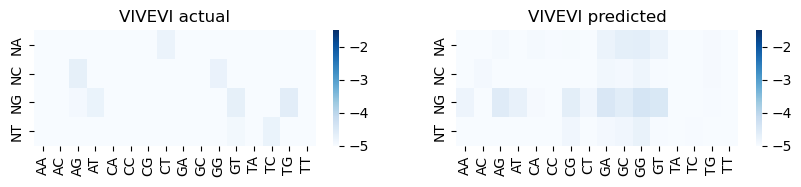

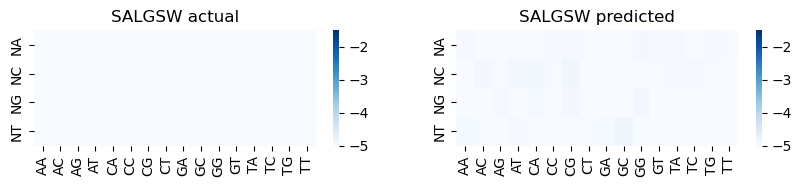

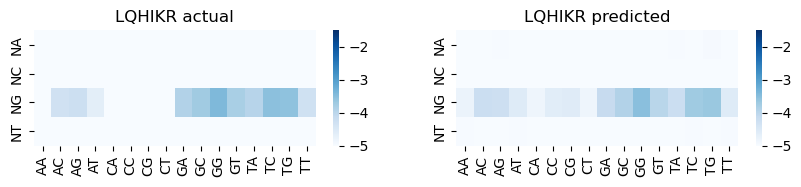

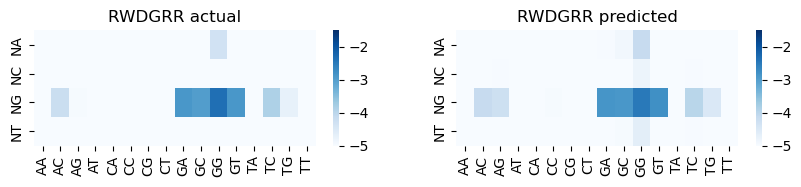

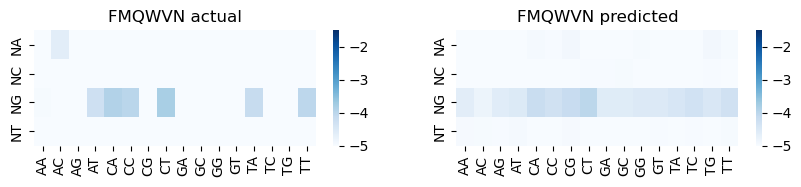

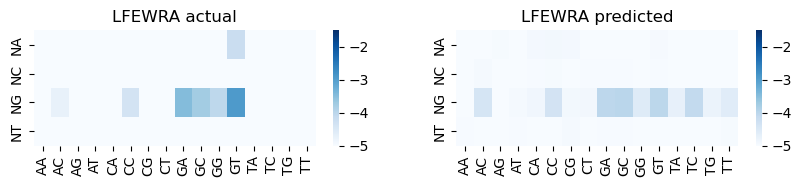

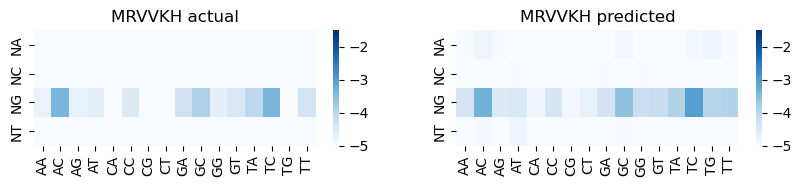

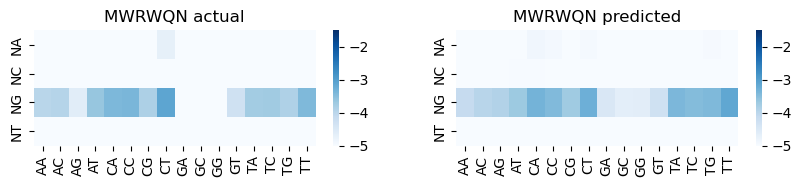

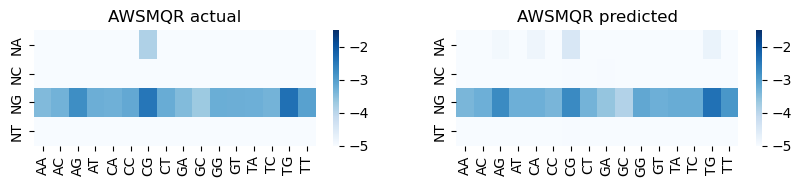

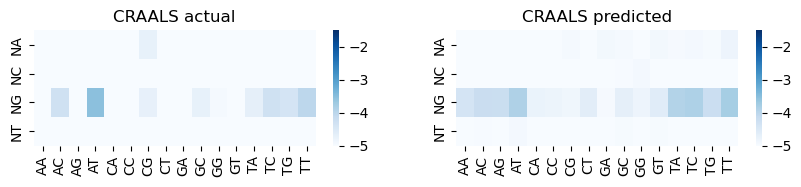

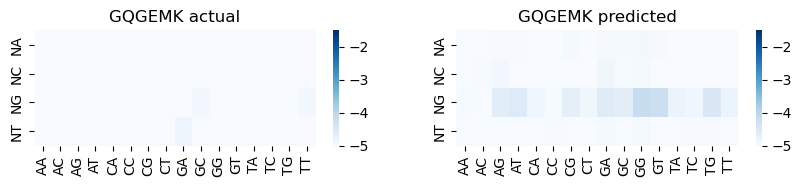

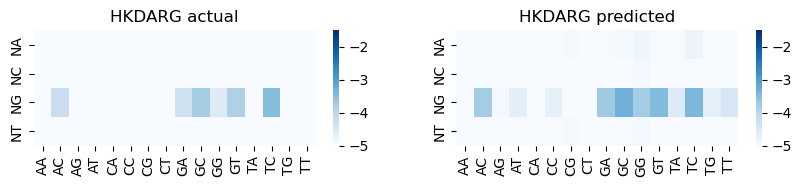

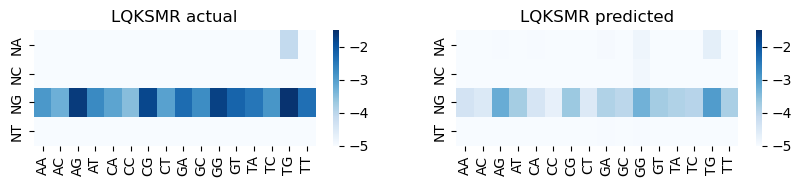

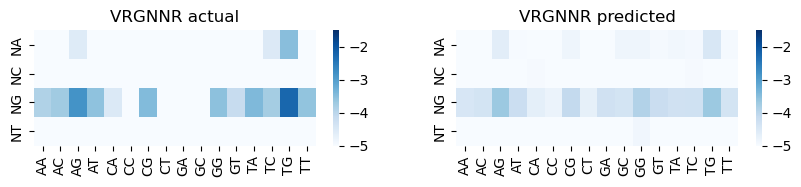

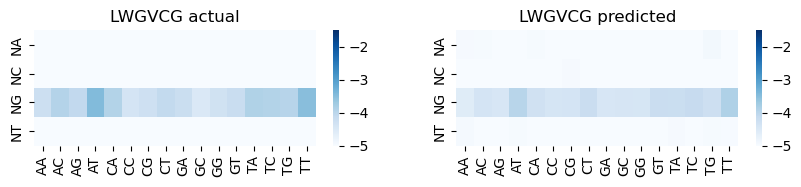

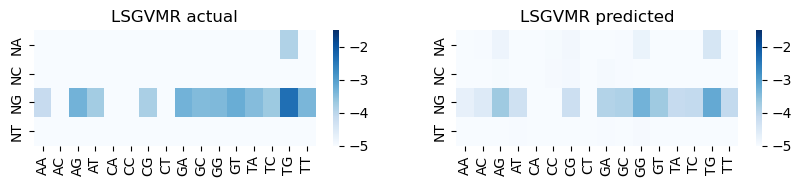

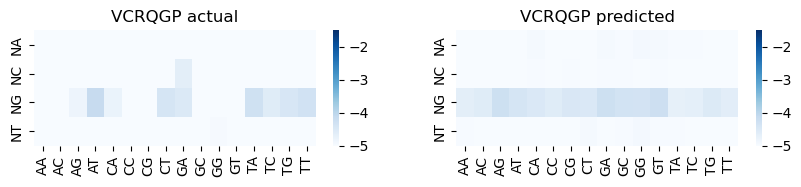

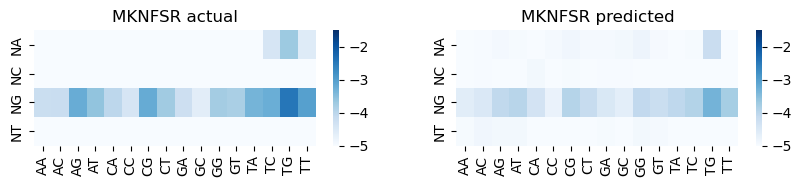

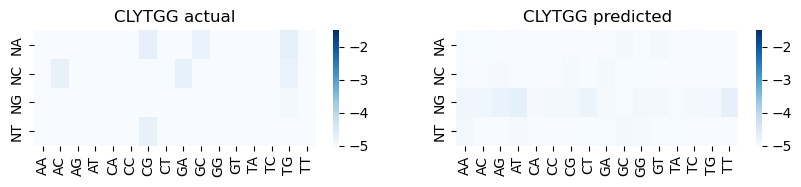

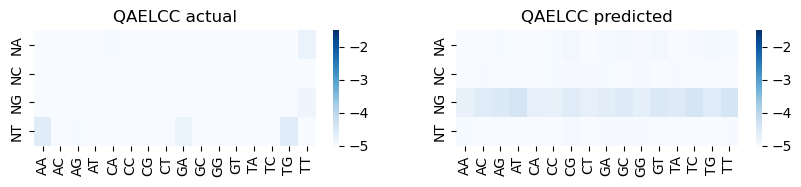

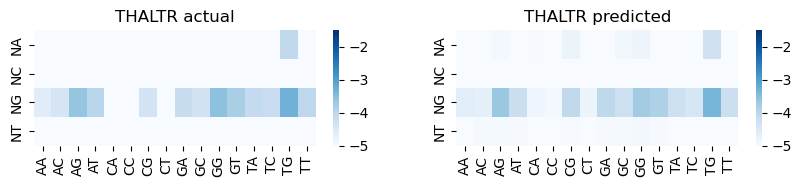

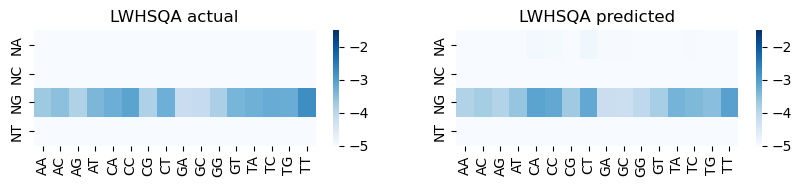

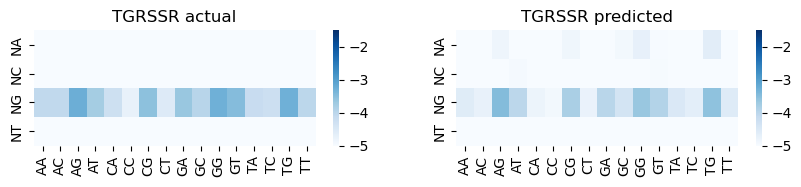

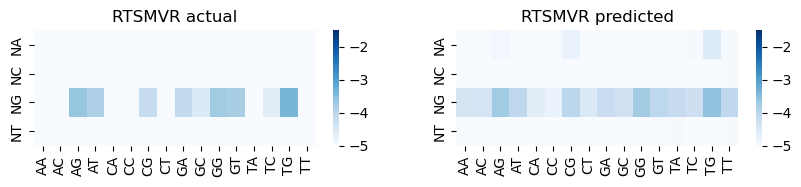

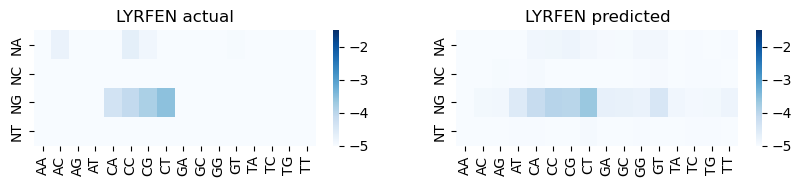

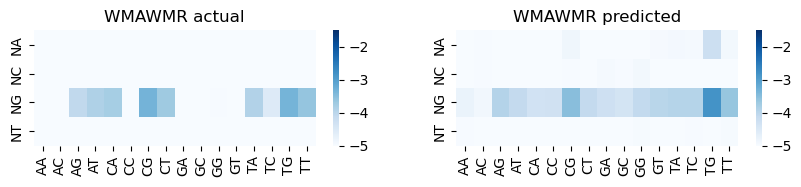

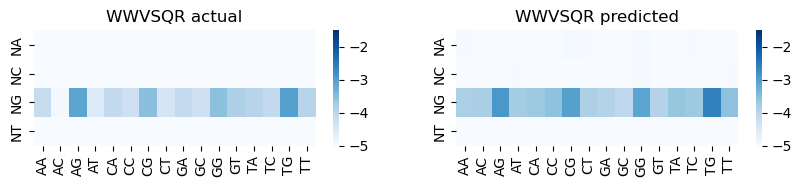

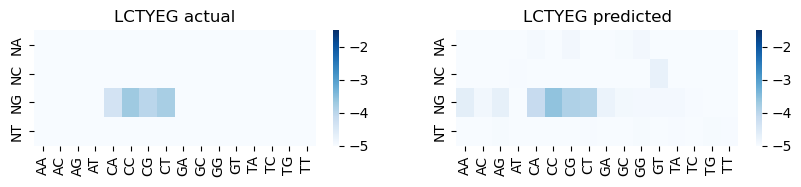

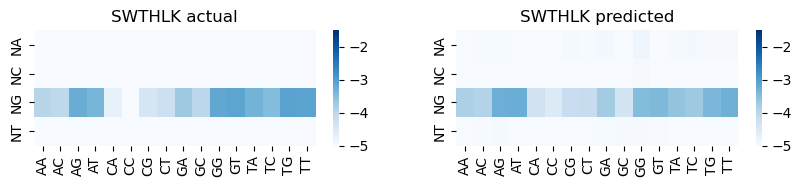

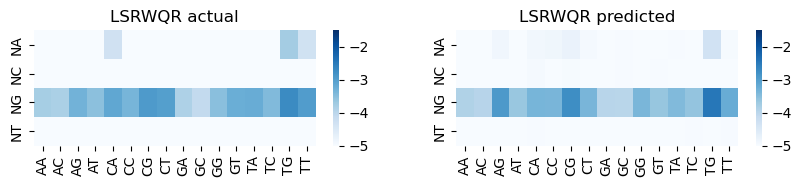

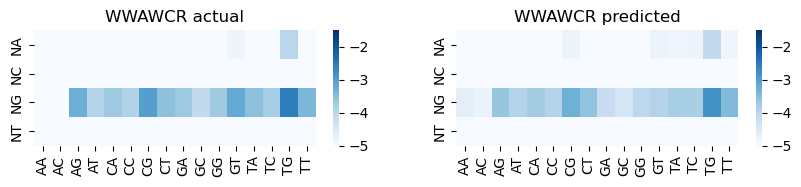

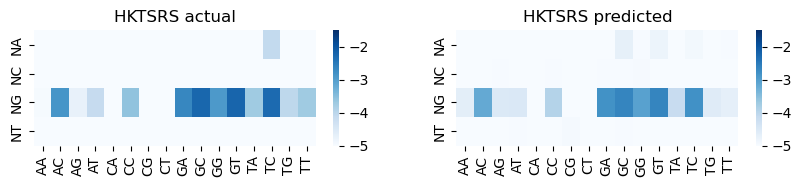

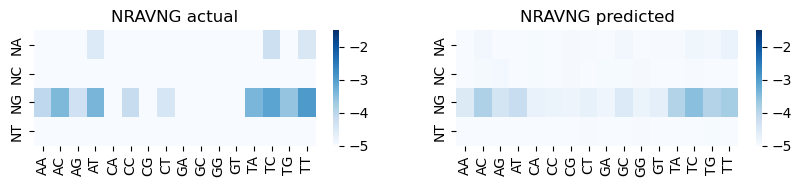

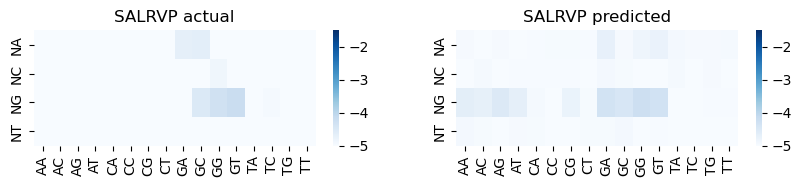

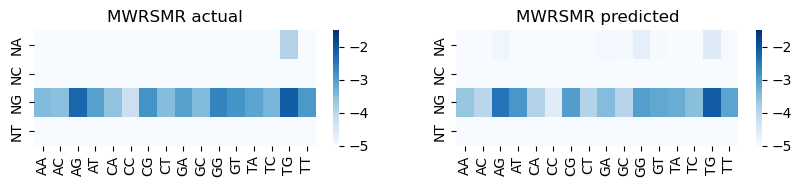

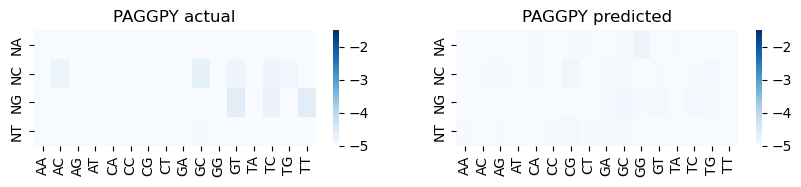

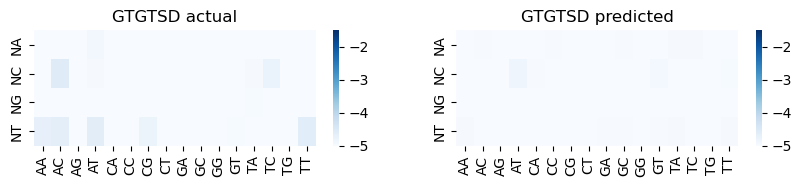

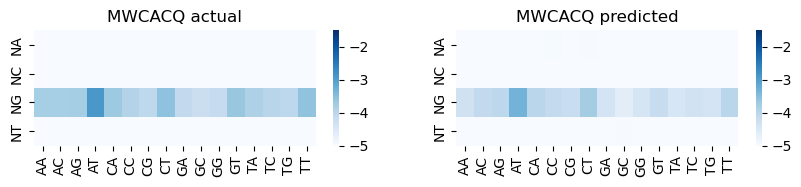

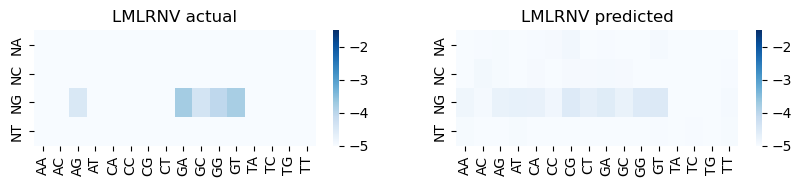

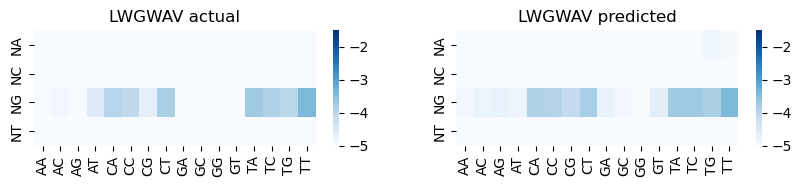

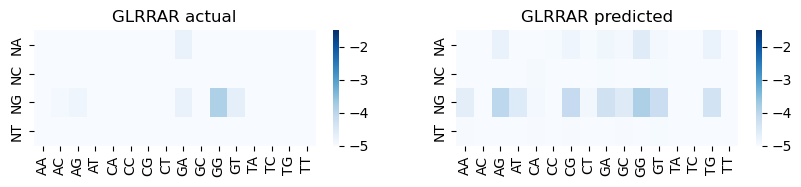

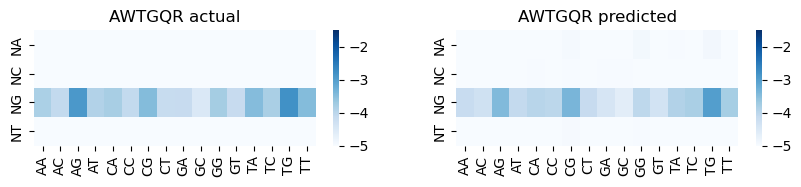

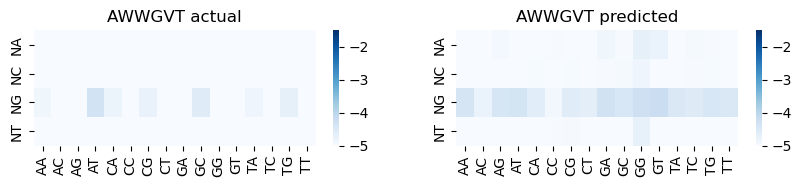

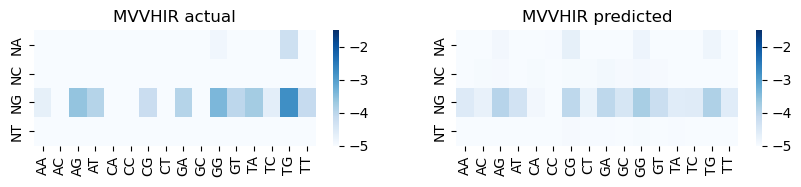

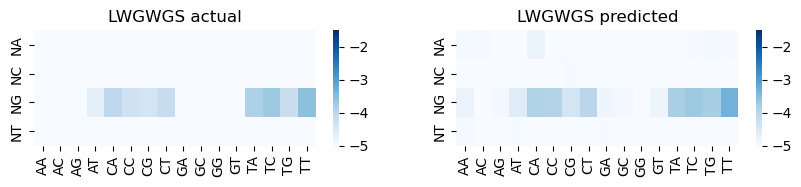

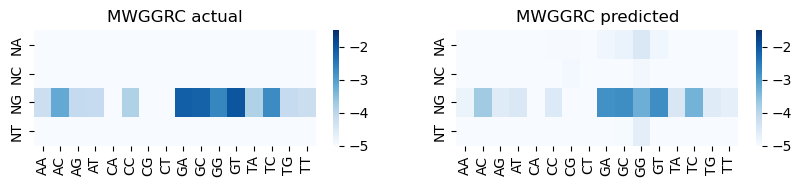

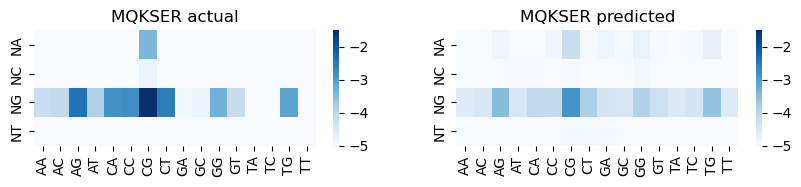

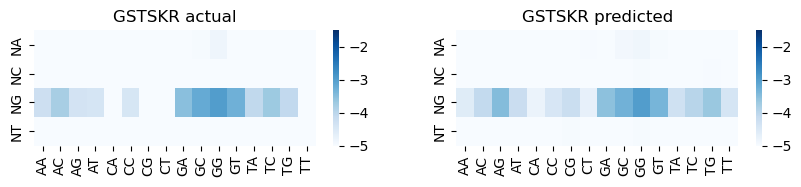

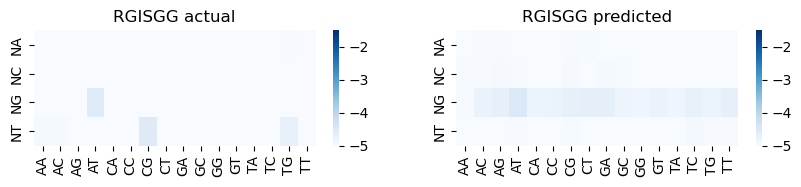

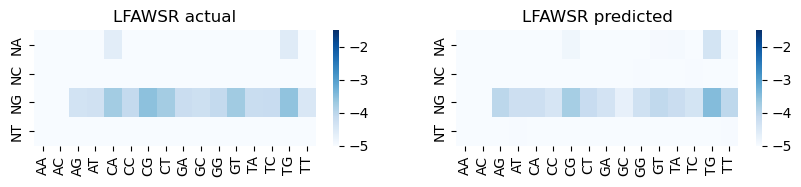

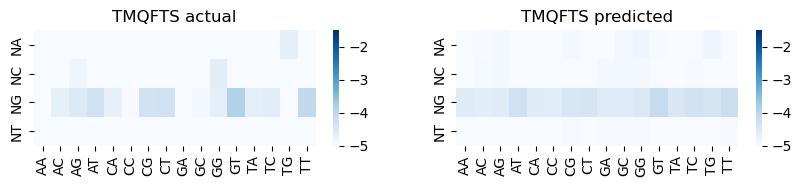

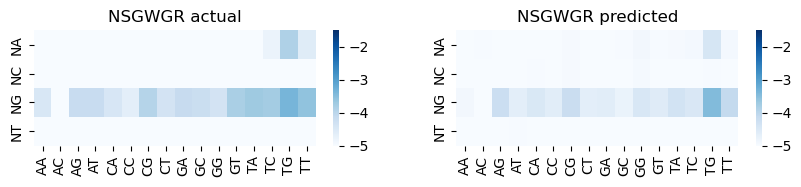

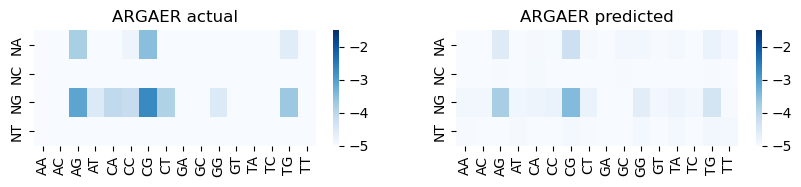

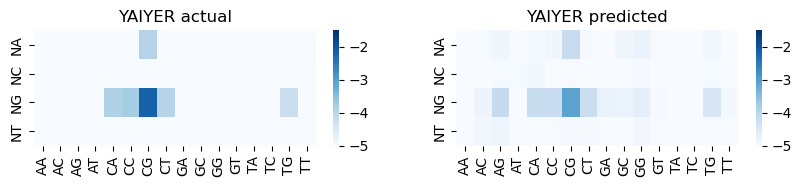

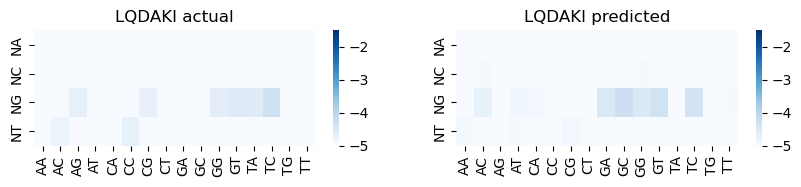

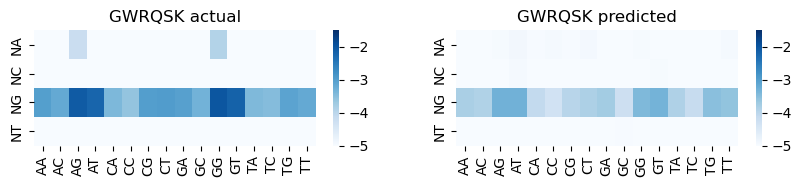

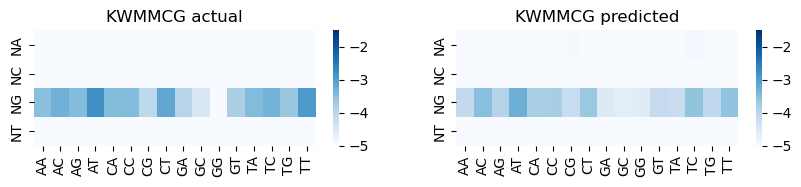

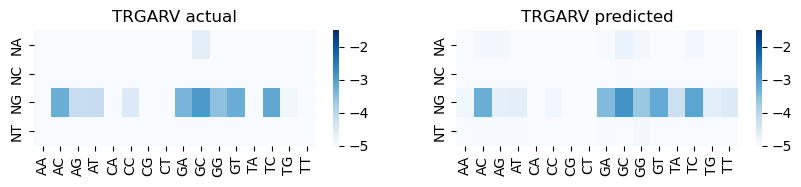

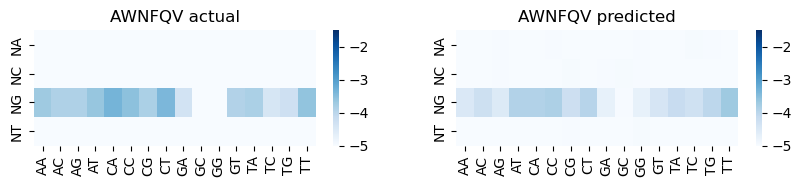

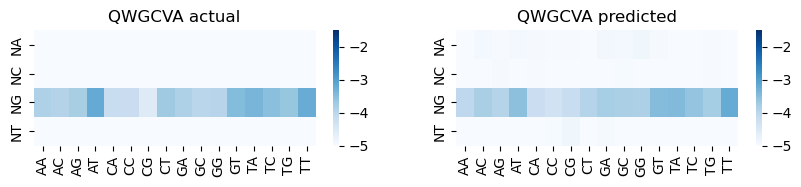

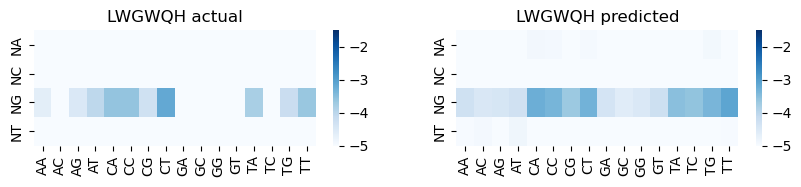

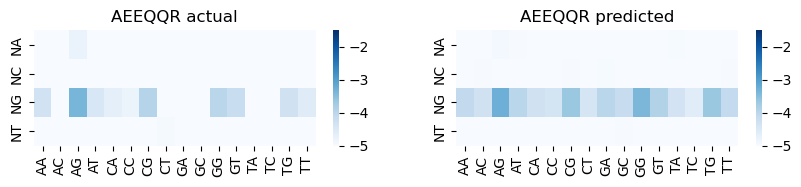

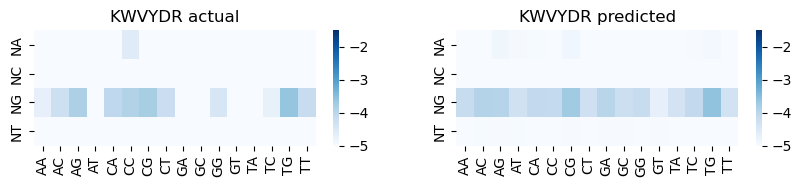

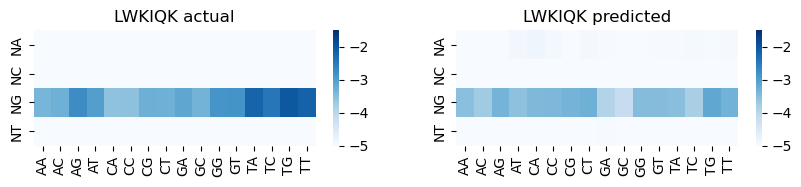

In [8]:
y_pred = regr.predict(x_test)
names = test_PAMDA_df.name

# unnormalize the data
y_pred_unnorm = unnormalize(y_pred, DATA_MEAN, DATA_STD)
y_test_unnorm = unnormalize(y_test, DATA_MEAN, DATA_STD)
np.savetxt(run_directory_path + "/test_set_predictions.csv",y_pred_unnorm, delimiter =",")
np.savetxt(run_directory_path + "/test_set_rates_actual.csv",y_test_unnorm, delimiter =",")

figs_dir = run_directory_path + "/figures"
if not os.path.isdir(figs_dir):
    os.mkdir(figs_dir)
plot_correlation(y_pred_unnorm, y_test_unnorm, run_directory_path + "/figures/test_set_correlation.png")
# get R^2 score
r2_test_set = r2_score(y_test_unnorm.flatten(), y_pred_unnorm.flatten())
print("R^2 on test set:", r2_test_set)  

for i in range(len(y_pred)):
    predicted = y_pred_unnorm[i]
    actual = y_test_unnorm[i]
    predicted = pd.DataFrame([predicted], columns = pams)
    actual = pd.DataFrame([actual], columns = pams)
    output_path = run_directory_path + "/figures/test_set_comparison_heatmaps"
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
    stripped_name = names[i].strip(r'[\\/*?:"<>|]')
    ax = plot_paired_heatmaps(actual, predicted, names[i], HEATMAP_MAX, HEATMAP_MIN)
    plt.savefig(output_path + "/" + stripped_name, bbox_inches='tight')
    plt.show()
    

In [9]:
filename = run_directory_path + "/model.pkl"
with open(filename, 'wb') as f:
    pickle.dump(regr, f)
    